# Yampa solar albedo comparison
*J. Michelle Hu  
University of Utah  
July 2024*  
---

In [1]:
import os
import sys
import xarray as xr
import numpy as np

from pathlib import PurePath
import pandas as pd
import hvplot.xarray
import rioxarray as riox
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/work/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

## Directory

In [4]:
basin = 'yampa'
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
basindirs = h.fn_list(workdir, f'*{basin}*')
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/yampa_100m_isnobal']

## Put in a SNOTEL point

In [5]:
# Convert to UTM EPSG 32613
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import pyproj

pyproj.datadir.set_data_dir('/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj')

# Create a Geoseries based off of a list of a Shapely point using the lat and lon from the SNOTEL site
s = gpd.GeoSeries([Point(352327, 4469125)])
s
# Turn this into a geodataframe and specify the geom as the geoseries of the SNOTEL point
gdf = gpd.GeoDataFrame(geometry=s)

# Set the CRS inplace
gdf.set_crs('epsg:32613', inplace=True)
gdf

,geometry
0,POINT (352327.000 4469125.000)


In [6]:
# Write this to file for the future
gdf.to_file('rabbit_ears_709.gpkg')

In [7]:
gdf3857 = gdf.to_crs(epsg=3857)
gdf3857

,geometry
0,POINT (-11882144.797 4918340.561)


In [8]:
# Write this to file for the future
gdf3857.to_file('rabbit_ears_709_epsg3857.gpkg')

In [6]:
figsize = (18, 4)
colors = []
linestyles = ['-', '--']

## Pull in the first month only

In [7]:
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run2019'
days = h.fn_list(basindirs[0], f"*/*/{month}*/smrf_energy*.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/smrf_energy*.nc")]
len(days)

2

In [8]:
smrf_fn = days[0][0]
smrf_fn

'/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/yampa_100m_isnobal/wy2020/yampa_basin_100m/run20191001/smrf_energy_balance_20191001.nc'

## Select a point and pull out a time series

### Open the datasets

In [9]:
%%time
ds_list = [xr.open_dataset(smrf_fn) for smrf_fn in days[0]]
ds_sol_list = [xr.open_dataset(smrf_fn) for smrf_fn in days[1]]

CPU times: user 1.54 s, sys: 1.22 s, total: 2.76 s
Wall time: 18.6 s


### Extract specified variable

In [10]:
%%time
thisvar = 'net_solar'
solar = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]
updated_solar = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_sol_list]

CPU times: user 234 ms, sys: 9.73 ms, total: 244 ms
Wall time: 245 ms


In [11]:
%%time
# Concatenate all the days
solar = xr.concat(solar, dim='time')
updated_solar = xr.concat(updated_solar, dim='time')

CPU times: user 2min 17s, sys: 11.4 s, total: 2min 29s
Wall time: 3min 29s


## Plot the net solar radiation overlaid

CPU times: user 25.1 ms, sys: 204 µs, total: 25.3 ms
Wall time: 48.9 ms


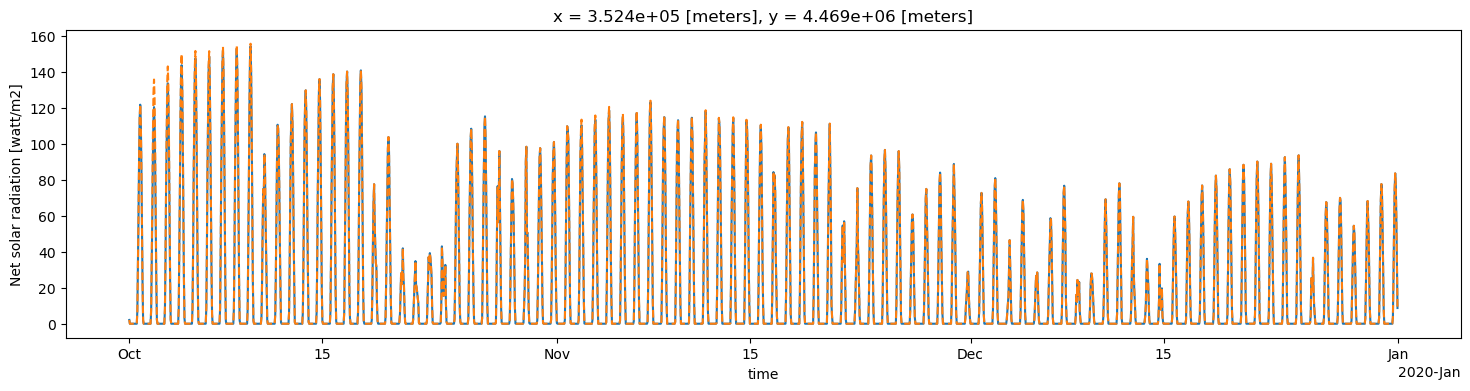

In [12]:
%%time
fig, ax = plt.subplots(1, figsize=figsize)
solar.plot(ax=ax, linestyle=linestyles[0])
updated_solar.plot(ax=ax, linestyle=linestyles[1])

## Plot the net solar radiation difference

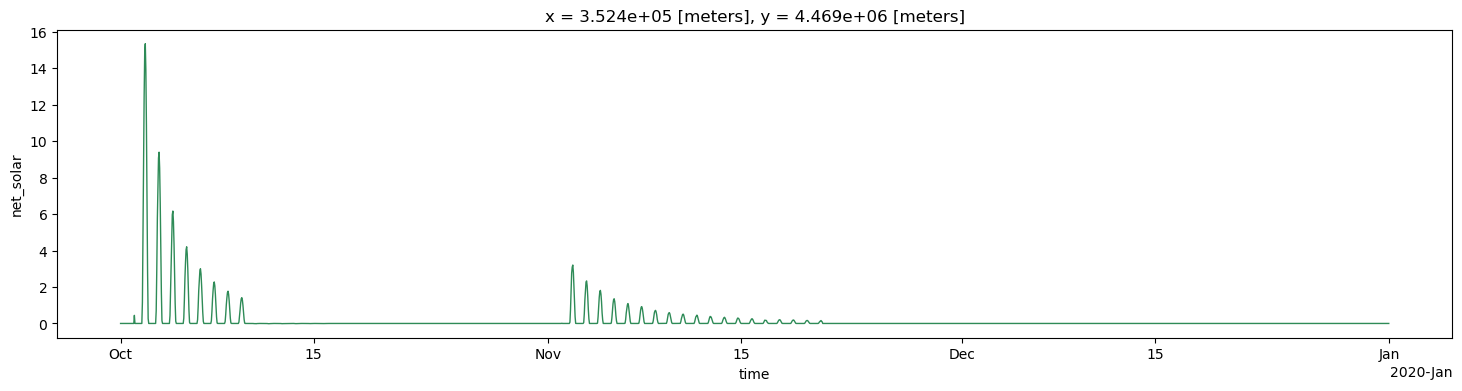

In [13]:
(updated_solar - solar).plot(figsize=figsize, color='seagreen', linewidth=1)

## Plot the albedo vis overlaid

In [14]:
%%time
thisvar = 'albedo_vis'
var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]
updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_sol_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')

CPU times: user 2min 28s, sys: 7.21 s, total: 2min 35s
Wall time: 3min 29s


CPU times: user 15.4 ms, sys: 36 µs, total: 15.5 ms
Wall time: 16 ms


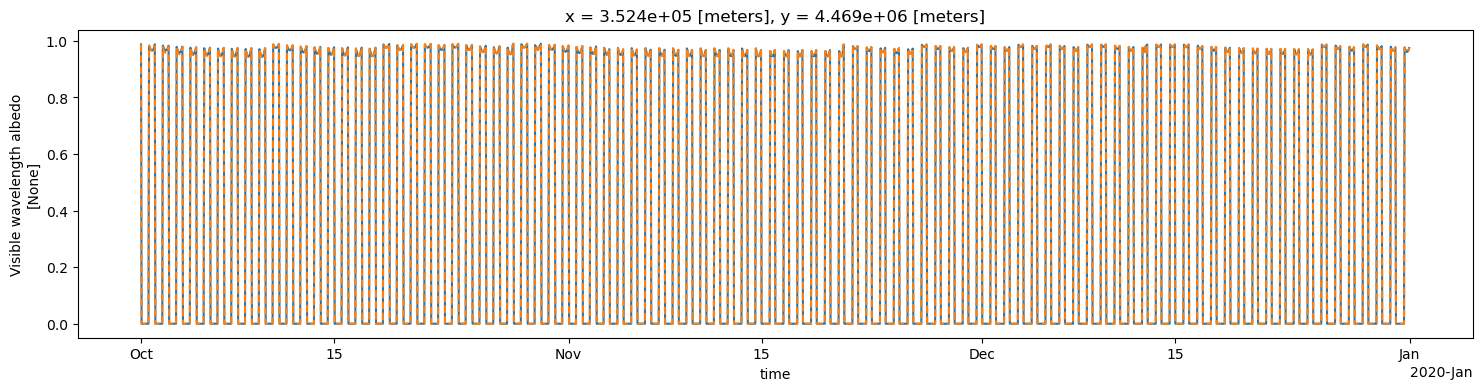

In [15]:
%%time
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, linestyle=linestyles[0])
updated_var_data.plot(ax=ax, linestyle=linestyles[1])

CPU times: user 13 ms, sys: 1.86 ms, total: 14.9 ms
Wall time: 14.5 ms


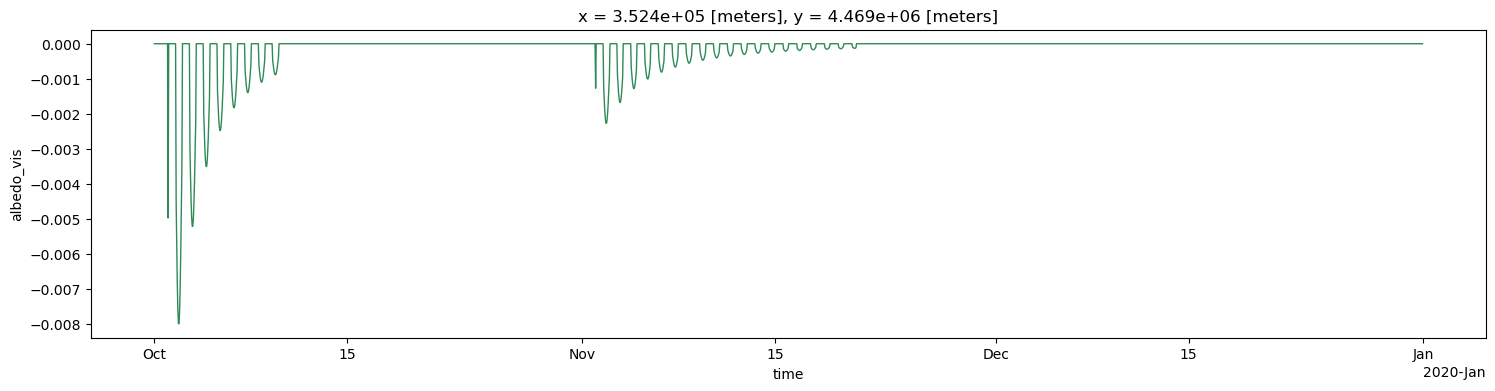

In [16]:
%%time
(updated_var_data - var_data).plot(figsize=figsize, color='seagreen', linewidth=1)

## Plot the albedo nir overlaid

In [17]:
%%time
thisvar = 'albedo_ir'
var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]
updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_sol_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')

CPU times: user 2min 31s, sys: 8.19 s, total: 2min 39s
Wall time: 3min 35s


CPU times: user 15.3 ms, sys: 27 µs, total: 15.3 ms
Wall time: 17.9 ms


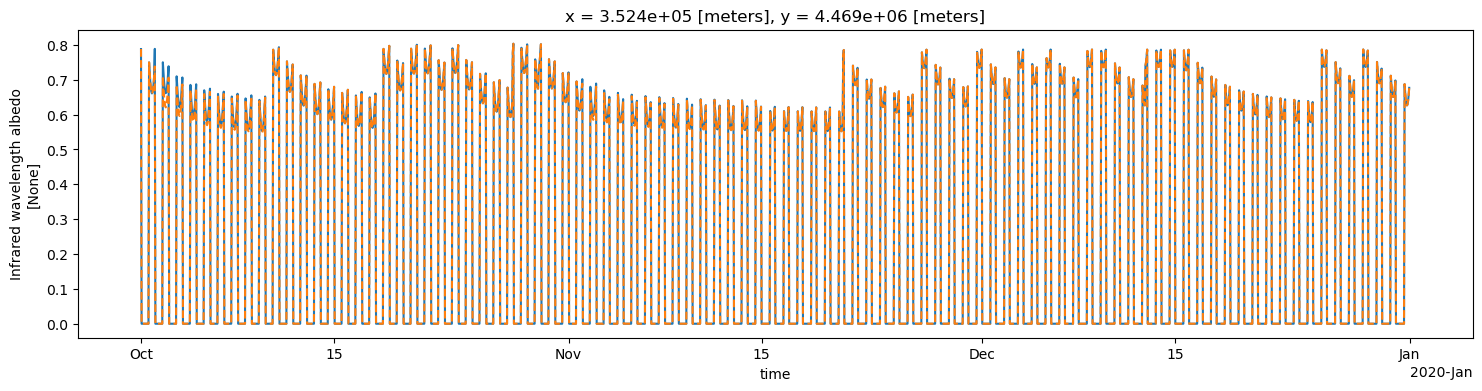

In [18]:
%%time
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, linestyle=linestyles[0])
updated_var_data.plot(ax=ax, linestyle=linestyles[1])

CPU times: user 14 ms, sys: 7 µs, total: 14 ms
Wall time: 13.8 ms


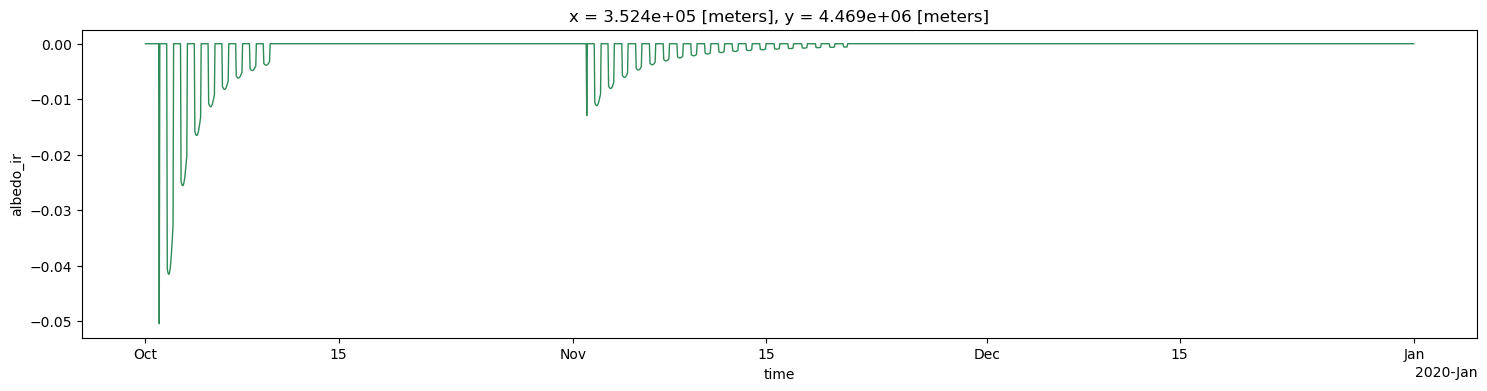

In [19]:
%%time
(updated_var_data - var_data).plot(figsize=figsize, color='seagreen', linewidth=1)

## Changes in net solar --> expect impacts on surface water inputs

In [20]:
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
# month = 'run2020'
days = h.fn_list(basindirs[0], f"*/*/{month}*/em.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/em.nc")]
len(days)

2

In [21]:
%%time
ds_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
ds_sol_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

CPU times: user 2.09 s, sys: 487 ms, total: 2.57 s
Wall time: 16.1 s


## At a point

In [22]:
%%time
thisvar = 'SWI'
var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]
updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_sol_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')

CPU times: user 1.65 s, sys: 1.51 s, total: 3.15 s
Wall time: 19.1 s


CPU times: user 14 ms, sys: 5 µs, total: 14 ms
Wall time: 13.8 ms


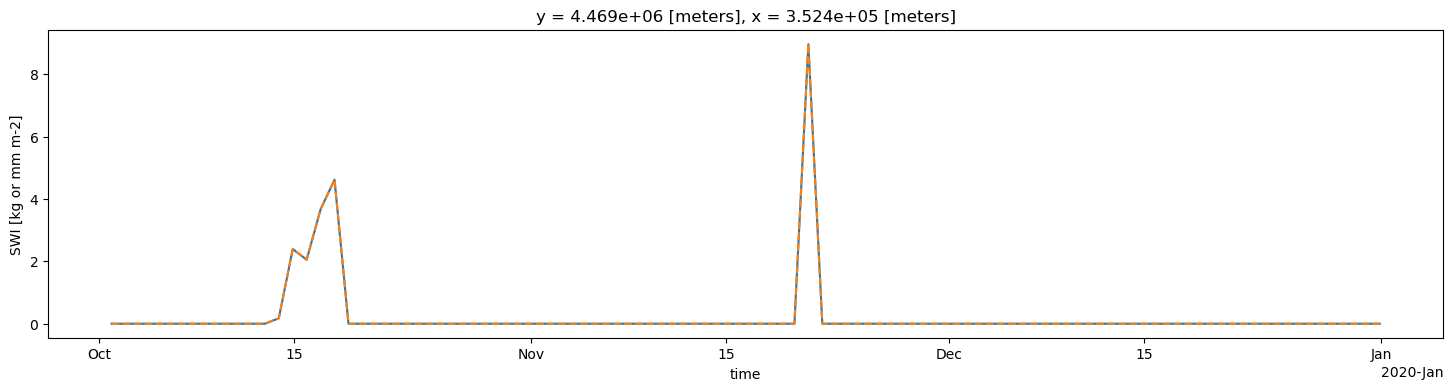

In [23]:
%%time
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, linestyle=linestyles[0])
updated_var_data.plot(ax=ax, linestyle=linestyles[1])

CPU times: user 10.9 ms, sys: 1.92 ms, total: 12.8 ms
Wall time: 12.6 ms


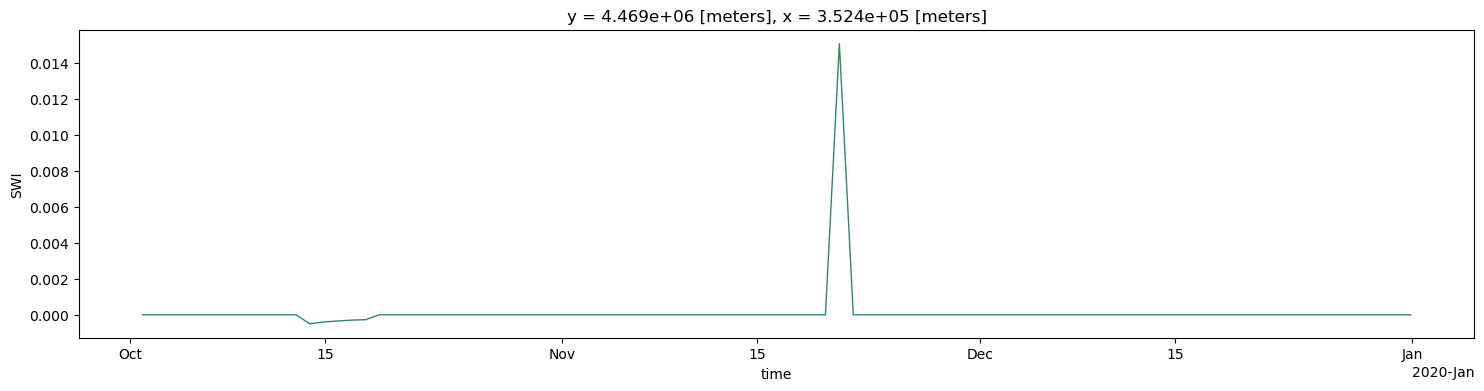

In [24]:
%%time
(updated_var_data - var_data).plot(figsize=figsize, color='seagreen', linewidth=1)

## Look at the snow depth at this point

In [33]:
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run2019'
days = h.fn_list(basindirs[0], f"*/*/{month}*/snow.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/snow.nc")]
len(days)

2

In [34]:
%%time
ds_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
ds_sol_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

CPU times: user 2.07 s, sys: 452 ms, total: 2.52 s
Wall time: 14.1 s


In [35]:
ds_list[0]

<xarray.Dataset> Size: 78MB
Dimensions:           (time: 1, y: 1043, x: 2086)
Coordinates:
  * time              (time) datetime64[ns] 8B 2019-10-01T22:00:00
  * y                 (y) float32 4kB 4.53e+06 4.53e+06 ... 4.426e+06 4.426e+06
  * x                 (x) float32 8kB 1.568e+05 1.569e+05 ... 3.653e+05
Data variables:
    thickness         (time, y, x) float32 9MB ...
    snow_density      (time, y, x) float32 9MB ...
    specific_mass     (time, y, x) float32 9MB ...
    liquid_water      (time, y, x) float32 9MB ...
    temp_surf         (time, y, x) float32 9MB ...
    temp_lower        (time, y, x) float32 9MB ...
    temp_snowcover    (time, y, x) float32 9MB ...
    thickness_lower   (time, y, x) float32 9MB ...
    water_saturation  (time, y, x) float32 9MB ...
    projection        |S1 1B ...

In [36]:
%%time
thisvar = 'thickness'
var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]
updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_sol_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')

CPU times: user 1.48 s, sys: 1.45 s, total: 2.93 s
Wall time: 4.2 s


CPU times: user 155 ms, sys: 1.86 ms, total: 157 ms
Wall time: 157 ms


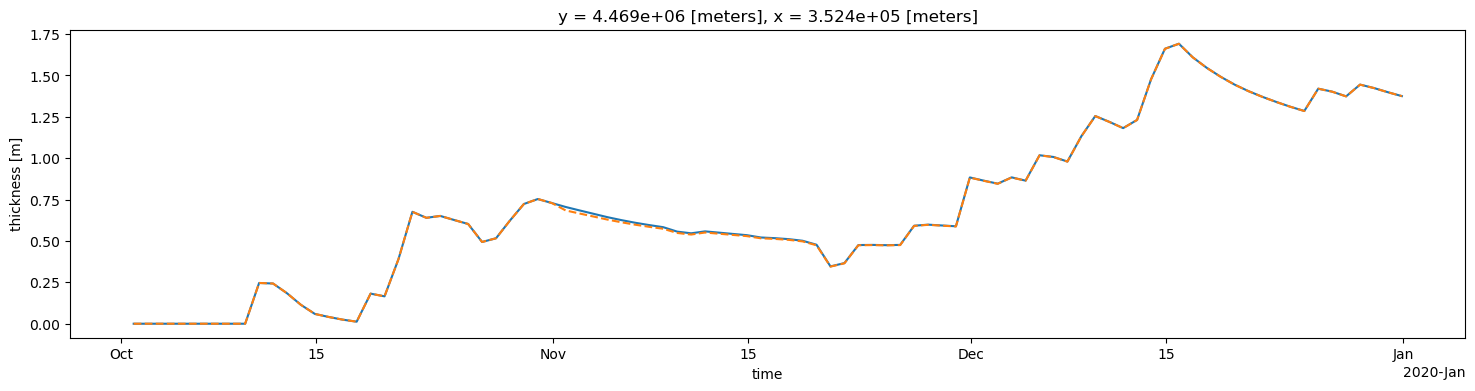

In [37]:
%%time
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, linestyle=linestyles[0])
updated_var_data.plot(ax=ax, linestyle=linestyles[1])

CPU times: user 13 ms, sys: 10 µs, total: 13.1 ms
Wall time: 12.7 ms


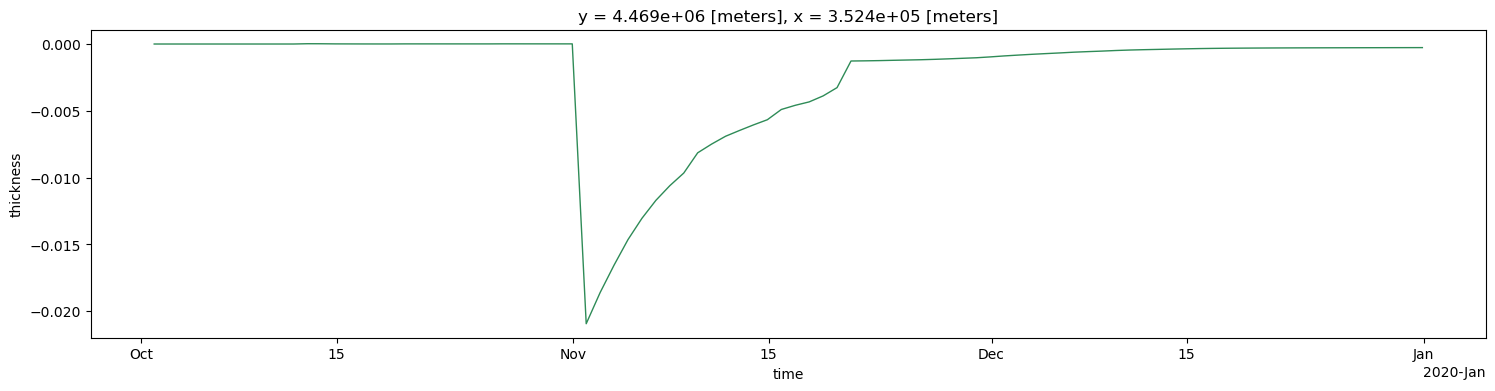

In [38]:
%%time
(updated_var_data - var_data).plot(figsize=figsize, color='seagreen', linewidth=1)